# Emotional Classification Pipeline

In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

## Install Packages

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, concatenate_datasets, Dataset
from peft import LoraConfig, get_peft_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, hamming_loss
from sklearn.model_selection import train_test_split
import torch
import random
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from transformers import MarianMTModel, MarianTokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import Dataset, concatenate_datasets
from collections import Counter
import math
import torch
import random
import gc
from tqdm.auto import tqdm
import warnings
import os
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    hamming_loss,
    multilabel_confusion_matrix
)

In [3]:
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # set_seed(seed)  # HuggingFace transformers seed


## Define Pipeline Parameters

In [4]:
model_name = "Davlan/afro-xlmr-small"  # Base model name
run_baseline = False # Set to True to run the baseline model (skip data augmentation)
languages = ["afr", "hau", "swa"] # List of languages to include, can be run on all languages/specific ones
# languages = ["afr"] # List of languages to include, can be run on all languages/specific ones
seed = 42 # Set a seed for reproducibility

emotion_labels = {
    "joy": 0,
    "anger": 1,
    "fear": 2,
    "sadness": 3,
    "disgust": 4,
    "surprise": 5,
    "neutral": 6,
}

set_all_seeds(seed)

## Load Datasets

In [5]:
def load_datasets(languages):
    # Load the datasets for the specified languages
    # datasets are in the form:
    # {
    #     "lang1": dataset1,
    #     "lang2": dataset2,
    #     ...
    # }

    datasets = {}
    for lang in languages:
        print(f"Loading dataset for {lang}...")
        hf_dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", lang)

        combined_hf_dataset = concatenate_datasets([
            hf_dataset["train"],
            hf_dataset["test"],
            hf_dataset["dev"]
        ])
        datasets[lang] = combined_hf_dataset
        print(f"Loaded {len(combined_hf_dataset)} samples for {lang}.")


    return datasets


datasets = load_datasets(languages)

Loading dataset for afr...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/91.2k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/12.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/150k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1222 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/196 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2130 [00:00<?, ? examples/s]

Loaded 3548 samples for afr.
Loading dataset for hau...


train-00000-of-00001.parquet:   0%|          | 0.00/150k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/31.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/146k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2145 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/712 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2160 [00:00<?, ? examples/s]

Loaded 5017 samples for hau.
Loading dataset for swa...


train-00000-of-00001.parquet:   0%|          | 0.00/240k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/56.1k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3307 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1102 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3312 [00:00<?, ? examples/s]

Loaded 7721 samples for swa.


## Preprocess Dataset
- Map empty emotions to neutral
- Split in to train, validation and test sets using stratified sampling by emotion label
- Add multi-hot encoded label column

In [6]:
def preprocess_datasets(datasets, emotion_to_id_dict):
    preprocessed_datasets = {}
    for lang, dataset in datasets.items():
        print(f"Preprocessing dataset for {lang}...")

        # Replace empty labels with "neutral"
        dataset = dataset.map(
            lambda example: {
                **example,
                "emotions": example["emotions"] if len(example["emotions"]) > 0 else ["neutral"]
            }
        )

        # Convert the list of emotions to a string representation for stratification
        def categorise_emotions(emotions_list):
            if not emotions_list:
                return "none"
            elif len(emotions_list) == 1:
                return emotions_list[0]
            else:
                return "multiple"

        # Add a new column for stratification
        dataset = dataset.map(
            lambda example: {"emotion_key": categorise_emotions(example["emotions"])}
        )

        # Now split using train_test_split from scikit-learn
        train_size = 0.8
        test_size = 0.1
        dev_size = 0.1

        # Convert to pandas for easier handling with sklearn
        df = dataset.to_pandas()

        print(f"Stratifying by emotion...")
        # First split to get train and the rest
        train_df, temp_df = train_test_split(
            df,
            train_size=train_size,
            stratify=df["emotion_key"],
            random_state=seed
        )

        # Then split the rest into test and dev
        test_df, dev_df = train_test_split(
            temp_df,
            train_size=test_size/(test_size + dev_size),
            stratify=temp_df["emotion_key"],
            random_state=seed
        )

        train_dataset = Dataset.from_pandas(train_df)
        test_dataset = Dataset.from_pandas(test_df)
        dev_dataset = Dataset.from_pandas(dev_df)


        num_labels = len(emotion_to_id_dict)

        # Create a new column 'labels' containing multi-hot encoded labels
        def map_emotions_to_labels(example):
            # Initialise a zero array for all emotions
            labels = [0.0] * num_labels  # Use floats instead of integers

            # Handle both string format and list format
            emotions_list = example['emotions']

            # Set 1 for each emotion present in the example
            for emotion in emotions_list:
                labels[emotion_to_id_dict[emotion]] = 1.0

            example['labels'] = labels
            return example

        # Apply the mapping function to the train, test, and dev datasets
        train_dataset = train_dataset.map(map_emotions_to_labels)
        test_dataset = test_dataset.map(map_emotions_to_labels)
        dev_dataset = dev_dataset.map(map_emotions_to_labels)


        print(f"Dataset for {lang} split with {len(train_dataset)} train, {len(test_dataset)} test, and {len(dev_dataset)} validation samples.")

        # Store the datasets in the dictionary
        preprocessed_datasets[lang] = {
            "train": train_dataset,
            "test": test_dataset,
            "validation": dev_dataset
        }
    return preprocessed_datasets


preprocessed_datasets = preprocess_datasets(datasets.copy(), emotion_labels)

Preprocessing dataset for afr...


Map:   0%|          | 0/3548 [00:00<?, ? examples/s]

Map:   0%|          | 0/3548 [00:00<?, ? examples/s]

Stratifying by emotion...


Map:   0%|          | 0/2838 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Dataset for afr split with 2838 train, 355 test, and 355 validation samples.
Preprocessing dataset for hau...


Map:   0%|          | 0/5017 [00:00<?, ? examples/s]

Map:   0%|          | 0/5017 [00:00<?, ? examples/s]

Stratifying by emotion...


Map:   0%|          | 0/4013 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Dataset for hau split with 4013 train, 502 test, and 502 validation samples.
Preprocessing dataset for swa...


Map:   0%|          | 0/7721 [00:00<?, ? examples/s]

Map:   0%|          | 0/7721 [00:00<?, ? examples/s]

Stratifying by emotion...


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

Dataset for swa split with 6176 train, 772 test, and 773 validation samples.


# Apply data augmentation techique
> Skips if running baseline model

In [7]:
warnings.filterwarnings("ignore")
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'



# Define language pairs for back translation
bt_languages = {
    "afr": ("af", "en", "helsinki"),
    "swa": ("swa_Latn", "eng_Latn", "nllb"),
    "hau": ("ha", "en", "helsinki"),
}

mapping = {
    "afr": "af",
    "swa": "sw",
    "hau": "ha"
}

def setup_colab_optimizations():
    """Setup optimizations specifically for Google Colab"""
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if device == "cuda":
        # Colab-specific optimizations
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.enabled = True

        # Clear any existing cache
        torch.cuda.empty_cache()
        gc.collect()

        # Print GPU info
        gpu_name = torch.cuda.get_device_name()
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"Using GPU: {gpu_name}")
        print(f"Total GPU Memory: {total_memory:.1f} GB")

        # Recommend batch size based on GPU
        if "T4" in gpu_name:
            recommended_batch = 20
        elif "P100" in gpu_name:
            recommended_batch = 16
        elif "V100" in gpu_name:
            recommended_batch = 32
        else:
            recommended_batch = 16

        print(f"Recommended batch size: {recommended_batch}")
        return device, recommended_batch

    return device, 8

def load_translation_models_fast(src_lang, tgt_lang, device, model_type="helsinki"):
    if model_type == "nllb":
        model_name = "facebook/nllb-200-distilled-600M"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32
        )
        model.to(device)
        model.eval()
        model.config.use_cache = True
        return tokenizer, model
    else:
        model_name = f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}"
        tokenizer = MarianTokenizer.from_pretrained(model_name)
        model = MarianMTModel.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32
        )
        model.to(device)
        model.eval()
        model.config.use_cache = True
        return tokenizer, model

def batch_translate_fast(texts, tokenizer, model, device, batch_size=20,src_lang=None, tgt_lang=None, model_type="helsinki"):
    """Batch translation optimized for Colab"""
    translated_texts = []

    # Pre-allocate list for better performance
    translated_texts = [None] * len(texts)
    processed = 0

    # Use larger batches and better progress tracking
    pbar = tqdm(total=len(texts), desc="Translating", unit="texts")

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        with torch.no_grad():
            if model_type == "nllb":
                tokenizer.src_lang = src_lang
                inputs = tokenizer(
                    batch,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=256,
                    # src_lang=src_lang
                )
                forced_bos_token_id = tokenizer.convert_tokens_to_ids(tgt_lang)
            else:
                inputs = tokenizer(
                    batch,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=256
                )

            # Move to device efficiently
            inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}

            # Fast generation
            if device == "cuda":
                with torch.amp.autocast("cuda"):
                    outputs = model.generate(
                        **inputs,
                        forced_bos_token_id=forced_bos_token_id if model_type == "nllb" else None,
                        max_length=256,
                        num_beams=1,
                        do_sample=False,
                        pad_token_id=tokenizer.pad_token_id,
                        use_cache=True
                    )
            else:
                outputs = model.generate(
                    **inputs,
                    forced_bos_token_id=forced_bos_token_id if model_type == "nllb" else None,
                    max_length=256,
                    num_beams=1,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id
                )

            decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            for j, text in enumerate(decoded):
                translated_texts[processed + j] = text
            processed += len(batch)
            pbar.update(len(batch))

            if i % (batch_size * 5) == 0 and device == "cuda":
                torch.cuda.empty_cache()

    pbar.close()
    return translated_texts

def get_label_counts(dataset):
    """Fast label counting"""
    emotion_counter = Counter()
    df = dataset.to_pandas()
    for emotions_list in df['emotions']:
        emotion_counter.update(emotions_list)
    return emotion_counter

def get_augmentation_targets(training_set):
    """Compute target number of augmented examples for each label based on distribution imbalance."""
    aug_targets = {}
    label_counts = get_label_counts(training_set)
    total_samples = len(training_set)
    num_labels = len(label_counts)
    ideal_distribution = 1 / num_labels

    for emotion, count in label_counts.items():
        current_percentage = count / total_samples
        print(f"{emotion}: {count} - {round(current_percentage * 100)}%")

        # Adaptive augmentation factor based on how underrepresented a label is
        if current_percentage >= 1.5 * ideal_distribution:
            print(f"Label {emotion} is overrepresented")
            augmentation_factor = 1.0
        elif current_percentage >= ideal_distribution:
            print(f"Label {emotion} is well represented")
            augmentation_factor = 1.3
        elif (ideal_distribution - current_percentage) <= 0.05:
            print(f"Label {emotion} is moderately represented")
            augmentation_factor = 2.0
        elif (ideal_distribution - current_percentage) <= 0.10:
            print(f"Label {emotion} is underrepresented")
            augmentation_factor = 3.0
        else:
            print(f"Label {emotion} is extremely underrepresented")
            augmentation_factor = 3.0

        target_count = int(count * augmentation_factor)
        num_to_augment = max(target_count - count, 0)
        aug_targets[emotion] = num_to_augment

    return aug_targets

def augment_datasets_colab(datasets, run_baseline=False):
    """Colab-optimized augmentation"""
    if run_baseline:
        print("Running baseline model, skipping data augmentation.")
        return datasets

    device, recommended_batch = setup_colab_optimizations()
    augmented = {}

    # Global model cache
    model_cache = {}

    for lang_idx, (lang, dataset) in enumerate(datasets.items()):
        print(f"\n{'='*50}")
        print(f"Processing {lang} ({lang_idx+1}/{len(datasets)})")
        print(f"{'='*50}")

        training_set = dataset["train"]
        label_counts = get_label_counts(training_set)
        aug_targets = get_augmentation_targets(training_set)

        print(f"Original label distribution:")
        for label, count in sorted(label_counts.items()):
            print(f"  {label}: {count}")

        if lang not in bt_languages:
            print(f" Skipping {lang}: not configured for back-translation.")
            augmented[lang] = dataset
            continue

        src_lang, tgt_lang, model_type = bt_languages[lang]

        # Load models with caching
        model_keys = [f"{src_lang}-{tgt_lang}-{model_type}", f"{tgt_lang}-{src_lang}-{model_type}"]

        for key in model_keys:
            if key not in model_cache:
                src, tgt, typ = key.split('-')
                print(f" Loading model: {src} → {tgt} ({typ})")
                model_cache[key] = load_translation_models_fast(src, tgt, device, model_type=typ)

        to_en_tok, to_en_model = model_cache[f"{src_lang}-{tgt_lang}-{model_type}"]
        to_src_tok, to_src_model = model_cache[f"{tgt_lang}-{src_lang}-{model_type}"]

        all_new_examples = []

        for label, num_needed in aug_targets.items():
            if num_needed == 0:
                continue

            samples = [ex for ex in training_set if label in ex["emotions"]]
            if not samples:
                continue

            print(f"\n Generating {num_needed} samples for '{label}'...")

            # Create expanded samples
            per_instance = math.ceil(num_needed / len(samples))
            expanded_samples = (samples * per_instance)[:num_needed]
            texts = [ex["text"] for ex in expanded_samples]

            try:
                # Step 1: Forward translation
                print(f"   Step 1/2: {src_lang} → {tgt_lang}")
                en_texts = batch_translate_fast(
                    texts, to_en_tok, to_en_model, device, recommended_batch,
                    src_lang=src_lang, tgt_lang=tgt_lang, model_type=model_type
                )

                # Step 2: Back translation
                print(f"   Step 2/2: {tgt_lang} → {src_lang}")
                bt_texts = batch_translate_fast(
                    en_texts, to_src_tok, to_src_model, device, recommended_batch,
                    src_lang=tgt_lang, tgt_lang=src_lang, model_type=model_type
                )

                # Create new examples efficiently
                new_examples = []
                for orig_ex, bt_text in zip(expanded_samples, bt_texts):
                    new_ex = orig_ex.copy()
                    new_ex["id"] = f"{orig_ex['id']}_bt_{random.randint(1000, 9999)}"
                    new_ex["text"] = bt_text
                    new_examples.append(new_ex)

                all_new_examples.extend(new_examples)
                print(f" Generated {len(new_examples)} samples")

            except Exception as e:
                print(f" Error for label '{label}': {e}")
                if device == "cuda":
                    torch.cuda.empty_cache()

        # Combine datasets
        if all_new_examples:
            augmented_train = concatenate_datasets([training_set, Dataset.from_list(all_new_examples)])
            print(f"\n Dataset size: {len(training_set)} → {len(augmented_train)} (+{len(all_new_examples)})")
        else:
            augmented_train = training_set
            print(f"\n No augmentation performed")

        # Show final distribution
        final_counts = get_label_counts(augmented_train)
        print(f"\nFinal label distribution:")
        for label, count in sorted(final_counts.items()):
            improvement = count - label_counts.get(label, 0)
            print(f"  {label}: {count} (+{improvement})")

        augmented[lang] = {
            "train": augmented_train,
            "test": dataset["test"],
            "validation": dataset["validation"]
        }

        # Cleanup after each language
        if device == "cuda":
            torch.cuda.empty_cache()
        gc.collect()

        # Show memory status
        if device == "cuda":
            allocated = torch.cuda.memory_allocated() / 1e9
            cached = torch.cuda.memory_reserved() / 1e9
            print(f"GPU Memory: {allocated:.1f}GB allocated, {cached:.1f}GB cached")

    print(f"\n Augmentation complete for all languages!")

    # Final cleanup
    del model_cache
    if device == "cuda":
        torch.cuda.empty_cache()
    gc.collect()

    return augmented

# Usage:
augmented_datasets = augment_datasets_colab(preprocessed_datasets.copy())

Using GPU: Tesla T4
Total GPU Memory: 15.8 GB
Recommended batch size: 20

Processing afr (1/3)
fear: 301 - 11%
Label fear is underrepresented
anger: 177 - 6%
Label anger is extremely underrepresented
disgust: 133 - 5%
Label disgust is extremely underrepresented
neutral: 1075 - 38%
Label neutral is overrepresented
joy: 1112 - 39%
Label joy is overrepresented
sadness: 439 - 15%
Label sadness is moderately represented
Original label distribution:
  anger: 177
  disgust: 133
  fear: 301
  joy: 1112
  neutral: 1075
  sadness: 439
 Loading model: af → en (helsinki)


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/819k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/297M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/297M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

 Loading model: en → af (helsinki)


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/819k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/297M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/297M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]


 Generating 602 samples for 'fear'...
   Step 1/2: af → en


Translating:   0%|          | 0/602 [00:00<?, ?texts/s]

   Step 2/2: en → af


Translating:   0%|          | 0/602 [00:00<?, ?texts/s]

 Generated 602 samples

 Generating 354 samples for 'anger'...
   Step 1/2: af → en


Translating:   0%|          | 0/354 [00:00<?, ?texts/s]

   Step 2/2: en → af


Translating:   0%|          | 0/354 [00:00<?, ?texts/s]

 Generated 354 samples

 Generating 266 samples for 'disgust'...
   Step 1/2: af → en


Translating:   0%|          | 0/266 [00:00<?, ?texts/s]

   Step 2/2: en → af


Translating:   0%|          | 0/266 [00:00<?, ?texts/s]

 Generated 266 samples

 Generating 439 samples for 'sadness'...
   Step 1/2: af → en


Translating:   0%|          | 0/439 [00:00<?, ?texts/s]

   Step 2/2: en → af


Translating:   0%|          | 0/439 [00:00<?, ?texts/s]

 Generated 439 samples

 Dataset size: 2838 → 4499 (+1661)

Final label distribution:
  anger: 862 (+685)
  disgust: 712 (+579)
  fear: 1144 (+843)
  joy: 1174 (+62)
  neutral: 1075 (+0)
  sadness: 1472 (+1033)
GPU Memory: 0.3GB allocated, 0.3GB cached

Processing hau (2/3)
neutral: 517 - 13%
Label neutral is moderately represented
fear: 608 - 15%
Label fear is well represented
sadness: 1223 - 30%
Label sadness is overrepresented
anger: 773 - 19%
Label anger is well represented
disgust: 623 - 16%
Label disgust is well represented
joy: 597 - 15%
Label joy is well represented
surprise: 652 - 16%
Label surprise is well represented
Original label distribution:
  anger: 773
  disgust: 623
  fear: 608
  joy: 597
  neutral: 517
  sadness: 1223
  surprise: 652
 Loading model: ha → en (helsinki)


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/783k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

 Loading model: en → ha (helsinki)


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/783k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]


 Generating 517 samples for 'neutral'...
   Step 1/2: ha → en


Translating:   0%|          | 0/517 [00:00<?, ?texts/s]

   Step 2/2: en → ha


Translating:   0%|          | 0/517 [00:00<?, ?texts/s]

 Generated 517 samples

 Generating 182 samples for 'fear'...
   Step 1/2: ha → en


Translating:   0%|          | 0/182 [00:00<?, ?texts/s]

   Step 2/2: en → ha


Translating:   0%|          | 0/182 [00:00<?, ?texts/s]

 Generated 182 samples

 Generating 231 samples for 'anger'...
   Step 1/2: ha → en


Translating:   0%|          | 0/231 [00:00<?, ?texts/s]

   Step 2/2: en → ha


Translating:   0%|          | 0/231 [00:00<?, ?texts/s]

 Generated 231 samples

 Generating 186 samples for 'disgust'...
   Step 1/2: ha → en


Translating:   0%|          | 0/186 [00:00<?, ?texts/s]

   Step 2/2: en → ha


Translating:   0%|          | 0/186 [00:00<?, ?texts/s]

 Generated 186 samples

 Generating 179 samples for 'joy'...
   Step 1/2: ha → en


Translating:   0%|          | 0/179 [00:00<?, ?texts/s]

   Step 2/2: en → ha


Translating:   0%|          | 0/179 [00:00<?, ?texts/s]

 Generated 179 samples

 Generating 195 samples for 'surprise'...
   Step 1/2: ha → en


Translating:   0%|          | 0/195 [00:00<?, ?texts/s]

   Step 2/2: en → ha


Translating:   0%|          | 0/195 [00:00<?, ?texts/s]

 Generated 195 samples

 Dataset size: 4013 → 5503 (+1490)

Final label distribution:
  anger: 1058 (+285)
  disgust: 850 (+227)
  fear: 814 (+206)
  joy: 803 (+206)
  neutral: 1034 (+517)
  sadness: 1462 (+239)
  surprise: 903 (+251)
GPU Memory: 0.6GB allocated, 0.6GB cached

Processing swa (3/3)
neutral: 2749 - 45%
Label neutral is overrepresented
joy: 830 - 13%
Label joy is moderately represented
surprise: 1000 - 16%
Label surprise is well represented
sadness: 647 - 10%
Label sadness is moderately represented
fear: 171 - 3%
Label fear is extremely underrepresented
anger: 586 - 9%
Label anger is moderately represented
disgust: 450 - 7%
Label disgust is underrepresented
Original label distribution:
  anger: 586
  disgust: 450
  fear: 171
  joy: 830
  neutral: 2749
  sadness: 647
  surprise: 1000
 Loading model: swa_Latn → eng_Latn (nllb)


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

 Loading model: eng_Latn → swa_Latn (nllb)

 Generating 830 samples for 'joy'...
   Step 1/2: swa_Latn → eng_Latn


Translating:   0%|          | 0/830 [00:00<?, ?texts/s]

   Step 2/2: eng_Latn → swa_Latn


Translating:   0%|          | 0/830 [00:00<?, ?texts/s]

 Generated 830 samples

 Generating 300 samples for 'surprise'...
   Step 1/2: swa_Latn → eng_Latn


Translating:   0%|          | 0/300 [00:00<?, ?texts/s]

   Step 2/2: eng_Latn → swa_Latn


Translating:   0%|          | 0/300 [00:00<?, ?texts/s]

 Generated 300 samples

 Generating 647 samples for 'sadness'...
   Step 1/2: swa_Latn → eng_Latn


Translating:   0%|          | 0/647 [00:00<?, ?texts/s]

   Step 2/2: eng_Latn → swa_Latn


Translating:   0%|          | 0/647 [00:00<?, ?texts/s]

 Generated 647 samples

 Generating 342 samples for 'fear'...
   Step 1/2: swa_Latn → eng_Latn


Translating:   0%|          | 0/342 [00:00<?, ?texts/s]

   Step 2/2: eng_Latn → swa_Latn


Translating:   0%|          | 0/342 [00:00<?, ?texts/s]

 Generated 342 samples

 Generating 586 samples for 'anger'...
   Step 1/2: swa_Latn → eng_Latn


Translating:   0%|          | 0/586 [00:00<?, ?texts/s]

   Step 2/2: eng_Latn → swa_Latn


Translating:   0%|          | 0/586 [00:00<?, ?texts/s]

 Generated 586 samples

 Generating 900 samples for 'disgust'...
   Step 1/2: swa_Latn → eng_Latn


Translating:   0%|          | 0/900 [00:00<?, ?texts/s]

   Step 2/2: eng_Latn → swa_Latn


Translating:   0%|          | 0/900 [00:00<?, ?texts/s]

 Generated 900 samples

 Dataset size: 6176 → 9781 (+3605)

Final label distribution:
  anger: 1282 (+696)
  disgust: 1441 (+991)
  fear: 545 (+374)
  joy: 1725 (+895)
  neutral: 2749 (+0)
  sadness: 1409 (+762)
  surprise: 1448 (+448)
GPU Memory: 3.1GB allocated, 3.1GB cached

 Augmentation complete for all languages!


# Tokenize the datasets

In [8]:
xmlr_tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(batch):
    return xmlr_tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = {}
for lang, dataset in augmented_datasets.items():
    print(f"Tokenizing dataset for {lang}...")
    tokenized_datasets[lang] = {}
    tokenized_datasets[lang]['train'] = dataset['train'].map(preprocess, batched=True)
    tokenized_datasets[lang]['test'] = dataset['test'].map(preprocess, batched=True)
    tokenized_datasets[lang]['validation'] = dataset['validation'].map(preprocess, batched=True)
    # Set the format for PyTorch
    tokenized_datasets[lang]['train'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    tokenized_datasets[lang]['test'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    tokenized_datasets[lang]['validation'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    print(f"Tokenized dataset for {lang}")



tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Tokenizing dataset for afr...


Map:   0%|          | 0/4499 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Tokenized dataset for afr
Tokenizing dataset for hau...


Map:   0%|          | 0/5503 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Tokenized dataset for hau
Tokenizing dataset for swa...


Map:   0%|          | 0/9781 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

Tokenized dataset for swa


# Train Model

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    probs = sigmoid(logits)
    preds = (probs >= 0.3).astype(int)

    # Get multilabel confusion matrix: shape (num_labels, 2, 2)
    mcm = multilabel_confusion_matrix(labels, preds)

    # Convert to dict for logging/inspection
    confusion_dict = {
        f"label_{i}": {
            "tn": int(cm[0][0]),
            "fp": int(cm[0][1]),
            "fn": int(cm[1][0]),
            "tp": int(cm[1][1]),
        }
        for i, cm in enumerate(mcm)
    }

    # Use macro and micro averages for evaluation
    return {
        "subset_accuracy": accuracy_score(labels, preds),
        "hamming_loss": hamming_loss(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
        "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
        "macro_precision": precision_score(labels, preds, average="macro", zero_division=0),
        "micro_precision": precision_score(labels, preds, average="micro", zero_division=0),
        "macro_recall": recall_score(labels, preds, average="macro", zero_division=0),
        "micro_recall": recall_score(labels, preds, average="micro", zero_division=0),
        "confusion_matrix": confusion_dict
    }

def train_finetune(train_data, val_data, num_labels, lang):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type="multi_label_classification"  # Set problem type for multi-label
    )

    args = TrainingArguments(
        output_dir=f"{model_name}-{lang}-ft",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        save_strategy="no",
        report_to="none",
        logging_dir=None,
        seed=seed,  # Add seed to training arguments
        data_seed=seed,  # Add data seed for data loading
        dataloader_num_workers=0,  # Ensure deterministic data loading
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_data,
        eval_dataset=val_data,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return trainer


trainers = {}
for lang, datasets in augmented_datasets.items():
    print(f"\nTraining on {lang} dataset...")

    num_labels = len(emotion_labels)
    set_all_seeds(seed)
    trainers[lang] = train_finetune(tokenized_datasets[lang]["train"],tokenized_datasets[lang]["validation"], num_labels, lang)
    results = trainers[lang].evaluate(tokenized_datasets[lang]["validation"], metric_key_prefix="eval")
    print("Training Fine-tuning Accuracy:", results['eval_subset_accuracy'])
    print("Training Hamming Loss:", results['eval_hamming_loss'])
    print("Macro F1 Score", results['eval_macro_f1'])
    print("Micro F1 Score", results['eval_micro_f1'])
    print("Micro Precision", results['eval_micro_precision'])
    print("Micro Recall", results['eval_micro_recall'])
    print("Macro Precision", results['eval_macro_precision'])
    print("Macro Recall", results['eval_macro_recall'])
    print("Confusion Matrix", results['eval_confusion_matrix'])


Training on afr dataset...


config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/561M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.264200
1000,0.093000


Training Fine-tuning Accuracy: 0.7774647887323943
Training Hamming Loss: 0.056338028169014086
Macro F1 Score 0.6772347334505204
Micro F1 Score 0.8305084745762712
Micro Precision 0.8147268408551069
Micro Recall 0.8469135802469135
Macro Precision 0.694331559227715
Macro Recall 0.668916613079726
Confusion Matrix {'label_0': {'tn': 197, 'fp': 23, 'fn': 17, 'tp': 118}, 'label_1': {'tn': 329, 'fp': 2, 'fn': 9, 'tp': 15}, 'label_2': {'tn': 305, 'fp': 10, 'fn': 12, 'tp': 28}, 'label_3': {'tn': 287, 'fp': 12, 'fn': 6, 'tp': 50}, 'label_4': {'tn': 336, 'fp': 3, 'fn': 5, 'tp': 11}, 'label_5': {'tn': 355, 'fp': 0, 'fn': 0, 'tp': 0}, 'label_6': {'tn': 193, 'fp': 28, 'fn': 13, 'tp': 121}}

Training on hau dataset...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.374700
1000,0.260200
1500,0.171700


Training Fine-tuning Accuracy: 0.549800796812749
Training Hamming Loss: 0.10700056915196357
Macro F1 Score 0.7141557211209965
Micro F1 Score 0.7218934911242604
Micro Precision 0.6684931506849315
Micro Recall 0.7845659163987139
Macro Precision 0.6796069928773466
Macro Recall 0.7637165526077606
Confusion Matrix {'label_0': {'tn': 410, 'fp': 17, 'fn': 17, 'tp': 58}, 'label_1': {'tn': 365, 'fp': 44, 'fn': 17, 'tp': 76}, 'label_2': {'tn': 376, 'fp': 37, 'fn': 9, 'tp': 80}, 'label_3': {'tn': 278, 'fp': 77, 'fn': 19, 'tp': 128}, 'label_4': {'tn': 420, 'fp': 9, 'fn': 11, 'tp': 62}, 'label_5': {'tn': 388, 'fp': 34, 'fn': 26, 'tp': 54}, 'label_6': {'tn': 413, 'fp': 24, 'fn': 35, 'tp': 30}}

Training on swa dataset...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.386100
1000,0.340500
1500,0.291100
2000,0.239200
2500,0.194200


Step,Training Loss
500,0.386100
1000,0.340500
1500,0.291100
2000,0.239200
2500,0.194200
3000,0.158400


Training Fine-tuning Accuracy: 0.5472186287192755
Training Hamming Loss: 0.11864720014784698
Macro F1 Score 0.5358612601495731
Micro F1 Score 0.6241217798594848
Micro Precision 0.5909090909090909
Micro Recall 0.6612903225806451
Macro Precision 0.5312303257853609
Macro Recall 0.5588876592637
Confusion Matrix {'label_0': {'tn': 613, 'fp': 57, 'fn': 40, 'tp': 63}, 'label_1': {'tn': 665, 'fp': 37, 'fn': 31, 'tp': 40}, 'label_2': {'tn': 745, 'fp': 6, 'fn': 18, 'tp': 4}, 'label_3': {'tn': 646, 'fp': 45, 'fn': 37, 'tp': 45}, 'label_4': {'tn': 697, 'fp': 22, 'fn': 24, 'tp': 30}, 'label_5': {'tn': 550, 'fp': 93, 'fn': 40, 'tp': 90}, 'label_6': {'tn': 320, 'fp': 109, 'fn': 83, 'tp': 261}}


In [10]:
def plot_multilabel_roc(trainer, dataset, emotion_labels, lang):
    # Get raw predictions and labels
    outputs = trainer.predict(dataset)
    logits = outputs.predictions
    labels = outputs.label_ids

    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    probs = sigmoid(logits)  # Shape: [num_samples, num_labels]

    num_labels = len(emotion_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_labels):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    label_names = [None] * len(emotion_labels)
    for k, v in emotion_labels.items():
        label_names[v] = k

    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(num_labels):
        plt.plot(fpr[i], tpr[i], label=f"{label_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for Language: {lang}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Plotting ROC curve for afr


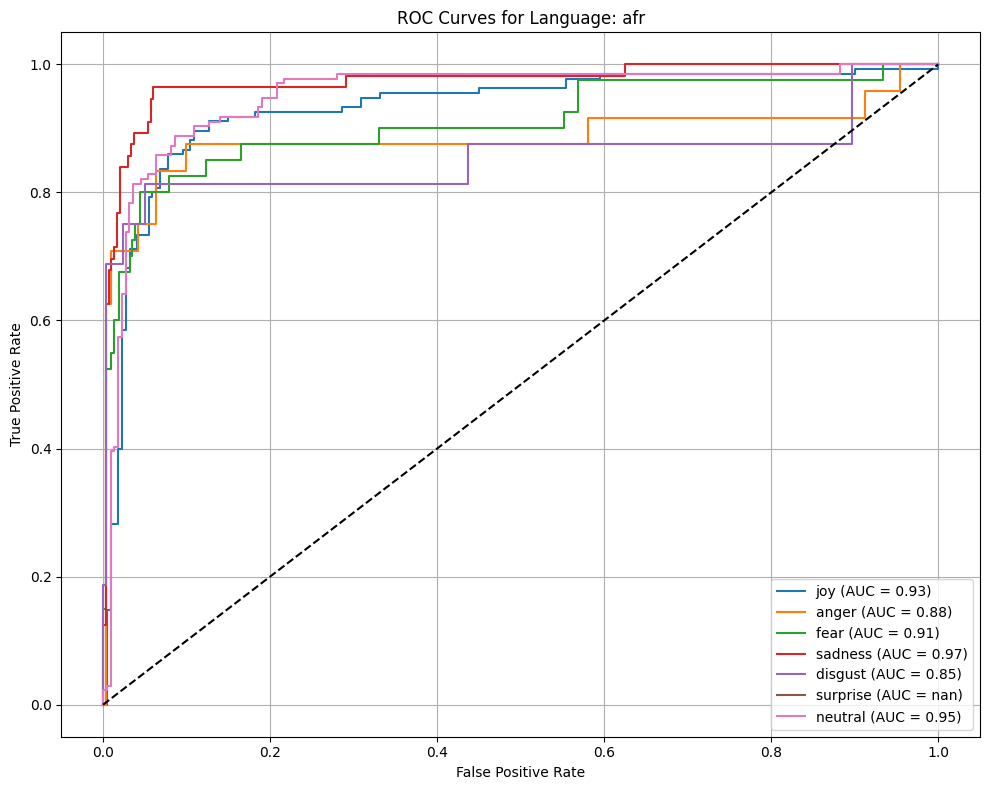

Plotting ROC curve for hau


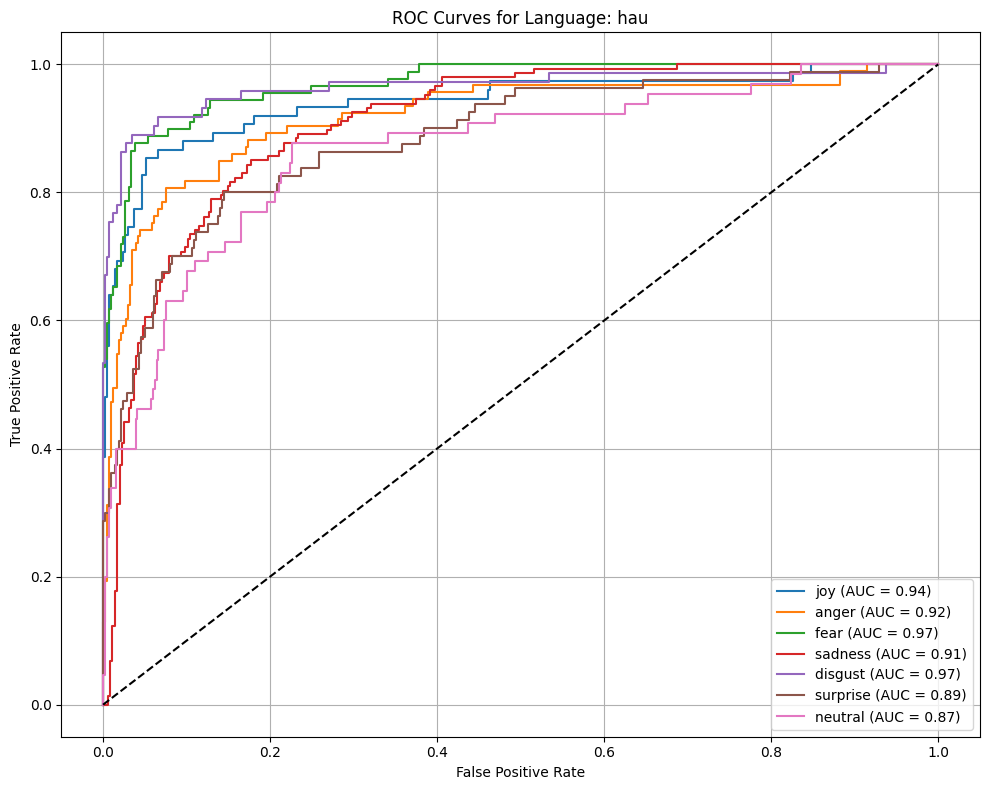

Plotting ROC curve for swa


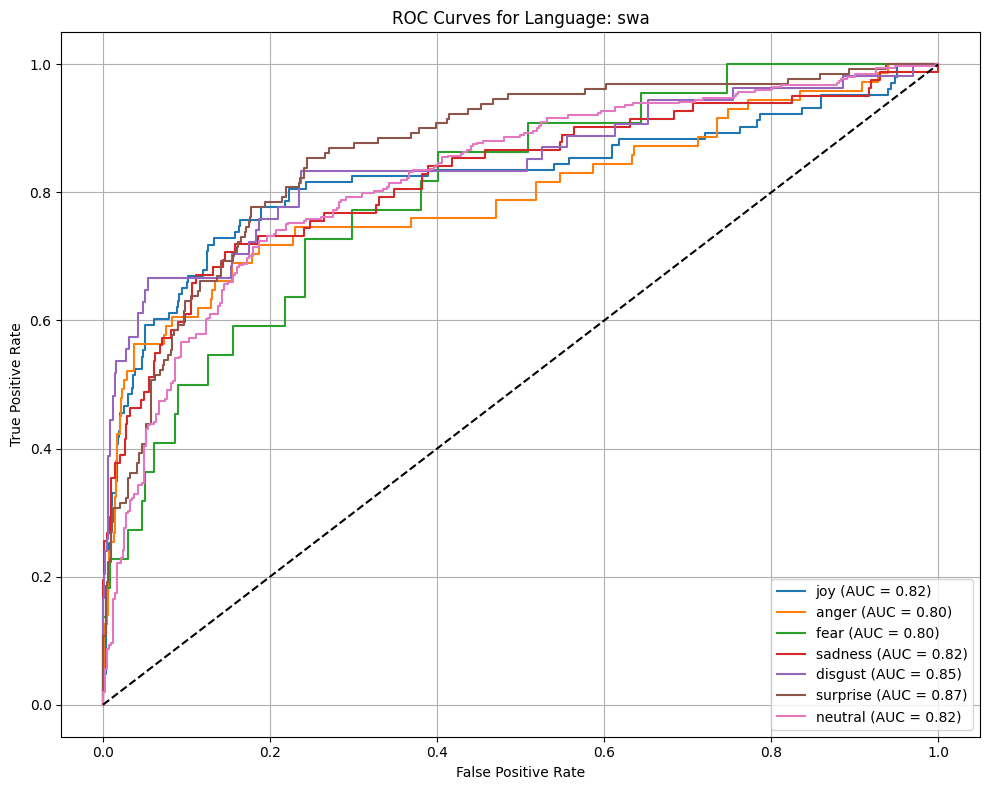

In [11]:
for lang in trainers:
    print(f"Plotting ROC curve for {lang}")
    plot_multilabel_roc(trainers[lang], tokenized_datasets[lang]["validation"], emotion_labels, lang)

# Test Model


Testing afr model on test afr dataset...


Test Accuracy: 0.7408450704225352
Test Hamming Loss: 0.06881287726358148
Test Macro F1 Score: 0.6666634298568331
Test Micro F1 Score: 0.7912087912087912
Test Micro Precision: 0.7864077669902912
Test Micro Recall: 0.7960687960687961
Test Macro Precision: 0.6867433507019968
Test Macro Recall: 0.6556489746533822
Test Confusion Matrix: {'label_0': {'tn': 195, 'fp': 22, 'fn': 23, 'tp': 115}, 'label_1': {'tn': 335, 'fp': 1, 'fn': 7, 'tp': 12}, 'label_2': {'tn': 295, 'fp': 18, 'fn': 12, 'tp': 30}, 'label_3': {'tn': 285, 'fp': 12, 'fn': 11, 'tp': 47}, 'label_4': {'tn': 338, 'fp': 2, 'fn': 3, 'tp': 12}, 'label_5': {'tn': 355, 'fp': 0, 'fn': 0, 'tp': 0}, 'label_6': {'tn': 187, 'fp': 33, 'fn': 27, 'tp': 108}}
Plotting ROC curve for afr


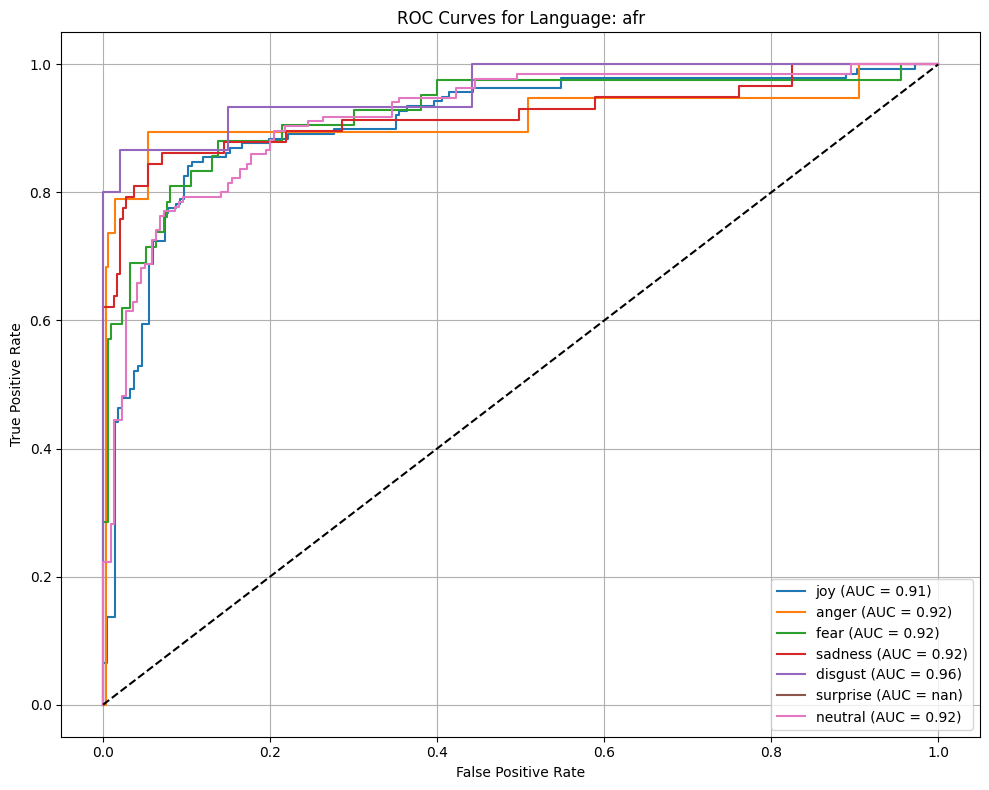


Testing hau model on test hau dataset...


Test Accuracy: 0.599601593625498
Test Hamming Loss: 0.09134889015367104
Test Macro F1 Score: 0.7513121104544072
Test Micro F1 Score: 0.756633813495072
Test Micro Precision: 0.7190201729106628
Test Micro Recall: 0.7984
Test Macro Precision: 0.7338253394558828
Test Macro Recall: 0.7821416467578169
Test Confusion Matrix: {'label_0': {'tn': 409, 'fp': 15, 'fn': 18, 'tp': 60}, 'label_1': {'tn': 374, 'fp': 34, 'fn': 17, 'tp': 77}, 'label_2': {'tn': 399, 'fp': 29, 'fn': 6, 'tp': 68}, 'label_3': {'tn': 286, 'fp': 65, 'fn': 14, 'tp': 137}, 'label_4': {'tn': 413, 'fp': 10, 'fn': 26, 'tp': 53}, 'label_5': {'tn': 393, 'fp': 24, 'fn': 24, 'tp': 61}, 'label_6': {'tn': 420, 'fp': 18, 'fn': 21, 'tp': 43}}
Plotting ROC curve for hau


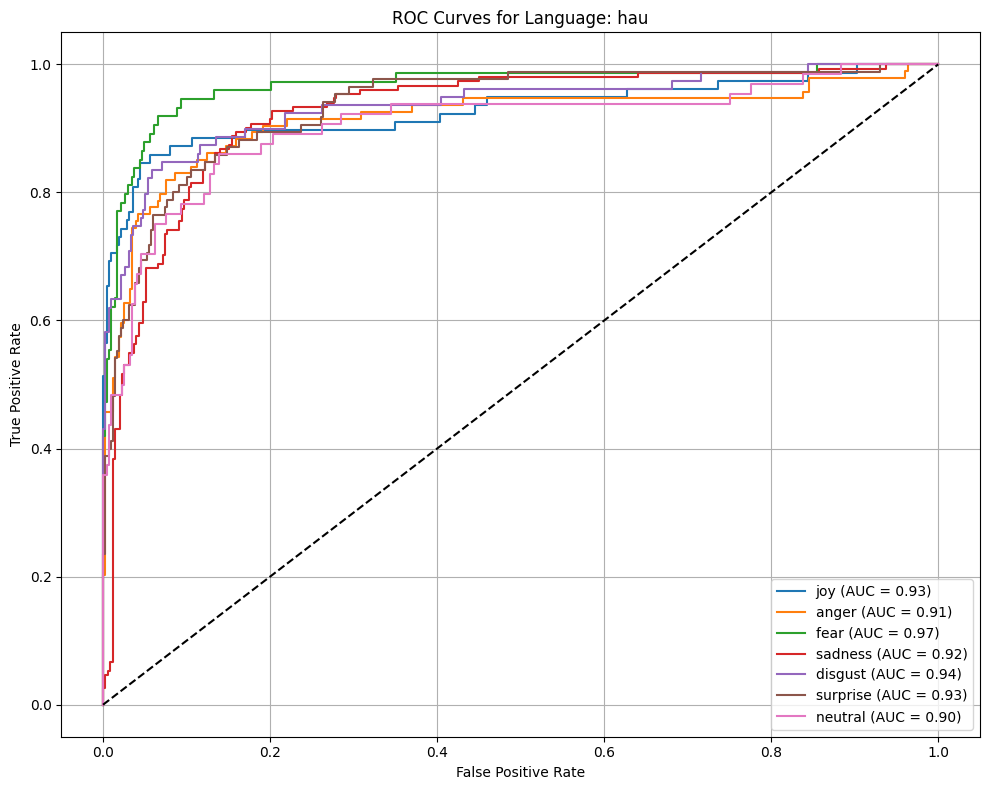


Testing swa model on test swa dataset...


Test Accuracy: 0.5816062176165803
Test Hamming Loss: 0.10899333826794967
Test Macro F1 Score: 0.5639383735506093
Test Micro F1 Score: 0.6533254855797528
Test Micro Precision: 0.6201117318435754
Test Micro Recall: 0.6902985074626866
Test Macro Precision: 0.5439974675568731
Test Macro Recall: 0.5919150476671611
Test Confusion Matrix: {'label_0': {'tn': 619, 'fp': 49, 'fn': 24, 'tp': 80}, 'label_1': {'tn': 659, 'fp': 41, 'fn': 29, 'tp': 43}, 'label_2': {'tn': 738, 'fp': 10, 'fn': 16, 'tp': 8}, 'label_3': {'tn': 641, 'fp': 46, 'fn': 41, 'tp': 44}, 'label_4': {'tn': 689, 'fp': 29, 'fn': 30, 'tp': 24}, 'label_5': {'tn': 582, 'fp': 68, 'fn': 38, 'tp': 84}, 'label_6': {'tn': 332, 'fp': 97, 'fn': 71, 'tp': 272}}
Plotting ROC curve for swa


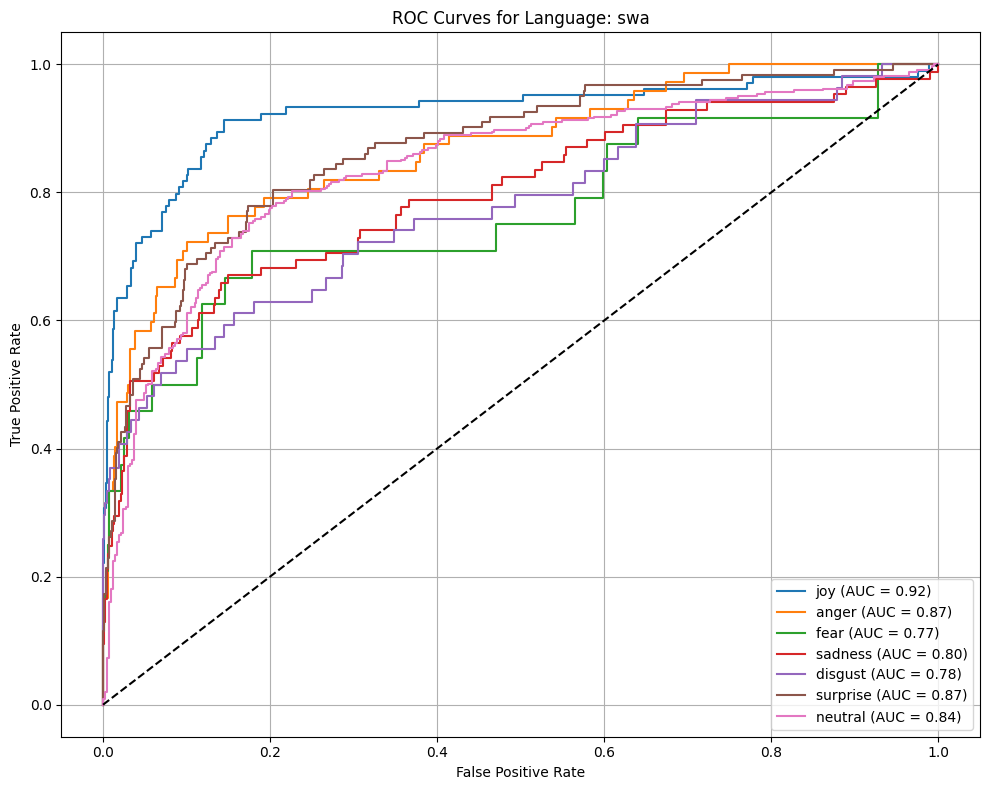

In [12]:
def test_model(trainer, test_data):
    # Reuse the already loaded tokenizer
    test_results = trainer.evaluate(
        test_data,
        metric_key_prefix="test"
    )

    print("Test Accuracy:", test_results['test_subset_accuracy'])
    print("Test Hamming Loss:", test_results['test_hamming_loss'])
    print("Test Macro F1 Score:", test_results['test_macro_f1'])
    print("Test Micro F1 Score:", test_results['test_micro_f1'])
    print("Test Micro Precision:", test_results['test_micro_precision'])
    print("Test Micro Recall:", test_results['test_micro_recall'])
    print("Test Macro Precision:", test_results['test_macro_precision'])
    print("Test Macro Recall:", test_results['test_macro_recall'])
    print("Test Confusion Matrix:", test_results['test_confusion_matrix'])

    return test_results

for lang, datasets in augmented_datasets.items():
    print(f"\nTesting {lang} model on test {lang} dataset...")
    test_results = test_model(trainers[lang], tokenized_datasets[lang]["test"])
    print(f"Plotting ROC curve for {lang}")
    plot_multilabel_roc(trainers[lang], tokenized_datasets[lang]["test"], emotion_labels, lang)


# Parameter Tuning

In [ ]:
# param_grid = {
#     "learning_rate": [2e-5, 3e-5, 5e-5],
#     "batch_size": [8, 16],
#     "epochs": [3, 5],
#     "threshold": [0.3, 0.5, 0.7]
# }


In [ ]:
# def train_finetune(model_ckpt, train_data, test_data, num_labels, lr, batch_size, epochs, threshold):
#     model = AutoModelForSequenceClassification.from_pretrained(
#         model_ckpt,
#         num_labels=num_labels,
#         problem_type="multi_label_classification"
#     )


#     args = TrainingArguments(
#         output_dir=f"{model_ckpt}-finetuned",
#         per_device_train_batch_size=batch_size,
#         per_device_eval_batch_size=batch_size,
#         learning_rate=lr,
#         num_train_epochs=epochs,
#         save_strategy="no",
#         report_to="none",
#         logging_dir=None,
#         seed=seed,  # Add seed to training arguments
#         data_seed=seed,  # Add data seed for data loading
#         dataloader_num_workers=0,  # Ensure deterministic data loading
#     )

#     def compute_metrics(eval_pred):
#         logits, labels = eval_pred
#         sigmoid = lambda x: 1 / (1 + np.exp(-x))
#         probs = sigmoid(logits)
#         preds = (probs >= threshold).astype(int)

#         return {
#             "subset_accuracy": accuracy_score(labels, preds),
#             "hamming_loss": hamming_loss(labels, preds),
#             "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
#             "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
#         }

#     trainer = Trainer(
#         model=model,
#         args=args,
#         train_dataset=train_data,
#         eval_dataset=test_data,
#         compute_metrics=compute_metrics
#     )

#     trainer.train()
#     results = trainer.evaluate()
#     return results


In [15]:
# import itertools
# import numpy as np
# from collections import defaultdict

# # Dictionary to store results for each language
# language_results = {}
# # Dictionary to track average performance across languages for each parameter combination
# param_avg_scores = defaultdict(float)
# # To count how many languages we test on (for averaging)
# num_languages = len(languages)

# # Create a compact parameter key format for readability
# def param_key(lr, batch_size, epochs, threshold):
#     return f"lr={lr}_bs={batch_size}_ep={epochs}_th={threshold}"

# print(f"Parameter tuning across {num_languages} languages: {', '.join(languages)}")

# num_labels = len(emotion_labels)
# # Generate all parameter combinations once
# param_combinations = list(itertools.product(
#     param_grid["learning_rate"],
#     param_grid["batch_size"],
#     param_grid["epochs"],
#     param_grid["threshold"]
# ))

# # First, train and evaluate on each language separately
# for lang in languages:
#     print(f"\n{'='*50}")
#     print(f"TUNING ON LANGUAGE: {lang}")
#     print(f"{'='*50}")

#     language_results[lang] = []
#     best_lang_score = 0
#     best_lang_params = {}

#     for lr, batch_size, epochs, threshold in param_combinations:
#         print(f"\nTesting on {lang}: lr={lr}, batch_size={batch_size}, epochs={epochs}, threshold={threshold}")

#         set_all_seeds(seed)
#         # Train and evaluate on this language with these parameters
#         results = train_finetune(
#             "Davlan/afro-xlmr-small",
#             tokenized_datasets[lang]["train"],
#             tokenized_datasets[lang]["validation"],
#             num_labels, lr, batch_size, epochs, threshold
#         )

#         # Extract the score (using micro_f1 as our metric)
#         score = results["eval_micro_f1"]
#         print(f"{lang} Micro-F1 Score: {score:.4f}")

#         # Store results for this language
#         language_results[lang].append((score, lr, batch_size, epochs, threshold))

#         # Update best parameters for this language
#         if score > best_lang_score:
#             best_lang_score = score
#             best_lang_params = {
#                 "learning_rate": lr,
#                 "batch_size": batch_size,
#                 "epochs": epochs,
#                 "threshold": threshold
#             }

#         # Add to our running average across languages
#         param_key_str = param_key(lr, batch_size, epochs, threshold)
#         param_avg_scores[param_key_str] += score / num_languages

#     # Print the best parameters for this language
#     print(f"\n✅ Best parameters for {lang}:")
#     print(best_lang_params)
#     print(f"Best {lang} Micro-F1 Score: {best_lang_score:.4f}")

# # Find the parameter combination with the best average performance across languages
# best_avg_score = 0
# best_avg_params = None

# for params, avg_score in param_avg_scores.items():
#     if avg_score > best_avg_score:
#         best_avg_score = avg_score
#         best_avg_params = params

# # Parse the parameter key back into a dictionary
# lr, batch_size, epochs, threshold = best_avg_params.split("_")
# best_params = {
#     "learning_rate": float(lr.split('=')[1]),
#     "batch_size": int(batch_size.split('=')[1]),
#     "epochs": int(epochs.split('=')[1]),
#     "threshold": float(threshold.split('=')[1])
# }

# print("\n" + "="*70)
# print("FINAL RESULTS ACROSS ALL LANGUAGES")
# print("="*70)
# print("\n✅ Best overall parameters (averaged across all languages):")
# print(best_params)
# print(f"Average Micro-F1 Score: {best_avg_score:.4f}")

# # Create a performance matrix to visualize results
# print("\nPerformance across languages:")
# print(f"{'Parameters':<40} | {'Average':<10} | " + " | ".join([f"{lang:<10}" for lang in languages]))
# print("-" * (50 + 12 * num_languages))

# # Sort parameter combinations by average score for better readability
# sorted_params = sorted(param_avg_scores.items(), key=lambda x: x[1], reverse=True)

# # Print top 5 parameter combinations
# for i, (params, avg_score) in enumerate(sorted_params[:5]):
#     # Get individual language scores for this parameter combination
#     lang_scores = []
#     for lang in languages:
#         # Find the score for this parameter combination in this language
#         for result in language_results[lang]:
#             score, lr, bs, ep, th = result
#             if param_key(lr, bs, ep, th) == params:
#                 lang_scores.append(score)
#                 break

#     # Print the row
#     print(f"{params:<40} | {avg_score:.4f}      | " + " | ".join([f"{score:.4f}      " for score in lang_scores]))
